# Backpropagation for Neural Networks

Quick example of training a single-hidden layer feedforward neural network, often called a multilayer perceptron (MLP). We'll introduce the <b>backpropagation</b> method to compute the gradients of this neural network and then learn the gradients with batch gradient descent.

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.stats import multivariate_normal as mvn

from sklearn.preprocessing import LabelBinarizer

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Dataset

Below I create a toy dataset similar to the one found in the [MLP example](mlp_pytorch.ipynb). Let $\mathcal{D} = \{(\mathbf{x}^{(i)}, y^{(i)})\}_{i=1}^N$ consist of $N$ iid samples, where $\mathbf{x} \in \mathbb{R}^2$ is two-dimensional and there are five classes $C=5$, such that $y \in \{0, 1, 2, 3, 4\}$. 

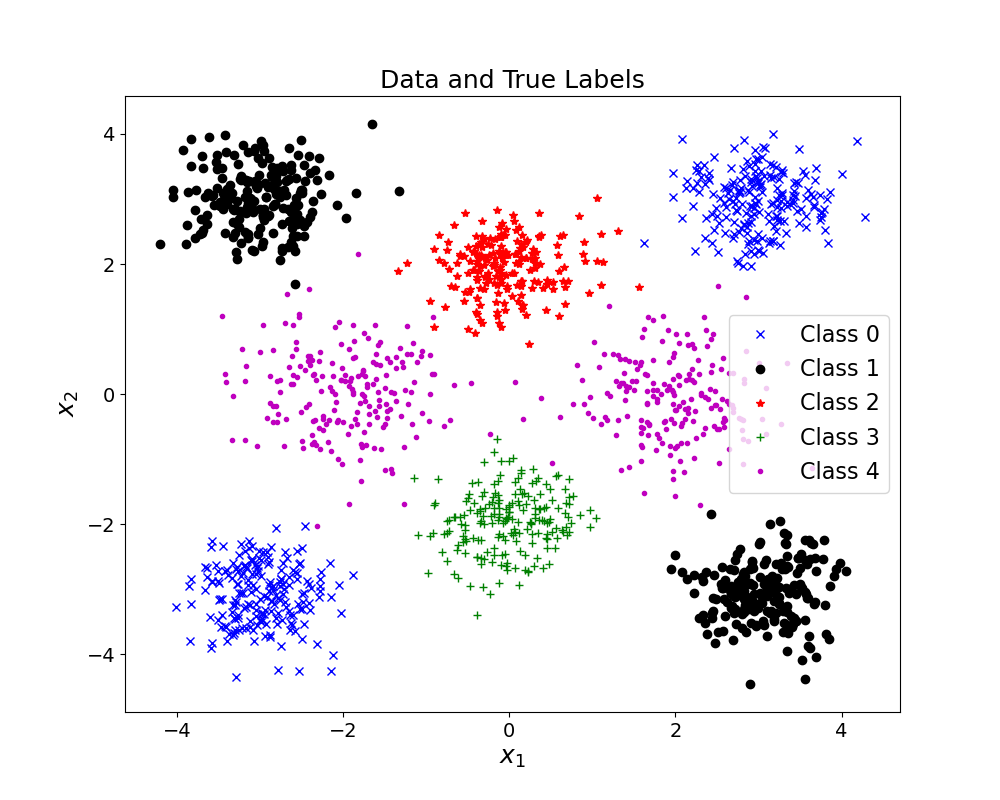

In [2]:
N = 200

def create_data(N, noise=0.2):
    # Uses the same covariance matrix, scaled identity, for all Gaussians
    Sigma = noise * np.eye(2)
    # Five gaussian means specified to span a square and its centre
    gaussians = [
        mvn(mean=[3, 3], cov=Sigma),
        mvn(mean=[-3, -3], cov=Sigma),
        mvn(mean=[3, -3], cov=Sigma),
        mvn(mean=[-3, 3], cov=Sigma),
        mvn(mean=[0, 2], cov=Sigma),
        mvn(mean=[0, -2], cov=Sigma),
        mvn(mean=[-2, 0], cov=2*Sigma),
        mvn(mean=[2, 0], cov=2*Sigma),
    ]
    # Draw random variable samples and assign labels, note class 3 has less samples altogether
    X = np.concatenate([g.rvs(size=N) for g in gaussians])
    y = np.concatenate((np.zeros(N), np.zeros(N), np.ones(N), np.ones(N), 
                        2 * np.ones(N), 3 * np.ones(N), 4 * np.ones(N), 4 * np.ones(N)))
    
    return X, y


X, y = create_data(N)
n = X.shape[1]
C = 5

plt.figure(figsize=(10,8))
plt.plot(X[y==0, 0], X[y==0, 1], 'bx', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'ko', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'r*', label="Class 2");
plt.plot(X[y==3, 0], X[y==3, 1], 'g+', label="Class 3");
plt.plot(X[y==4, 0], X[y==4, 1], 'm.', label="Class 4");
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Data and True Labels")
plt.legend()
plt.show()

## Forward Propagation

When we feed inputs $\mathbf{x} \in \mathbb{R}^n$ into a neural network, the outputs $\mathbf{o} \in \mathbb{R}^C$ and predictions $\hat{y} \in \mathbb{Z}$ are generated by flowing through the multiple layers in the network. If each hidden layer $l$ consists of a functional mapping from inputs/pre-activations $\mathbf{a}^{(l)} = \mathbf{b}^{(l)} + \mathbf{W}^{(l)}\mathbf{h}^{(l-1)}$ to activations $\mathbf{h}^{(l)} = g(\mathbf{a}^{(l)})$, then a network with $L$ layers can be viewed as a composition of these functions $\mathbf{f}(\mathbf{x}) = \mathbf{f}^{(L)}(\mathbf{f}^{(L-1)}(\cdots(\mathbf{f}^{(1)}(\mathbf{x}))\cdots))$. Propagating the original data through the hidden units at each layer all the way through to the output layer is known as <b>forward propagation</b>. <i>Note</i> that these functions are all <b>bolded</b> as I am being explicit about the fact that they are vector-valued functions, i.e., they have vector-valued outputs.

Using the notation from the lectures, we can write the forward pass for our $L=1$ layer classification setting as follows:

\begin{align}
\mathbf{o} = \mathbf{f}(\mathbf{x}) & = \mathbf{S}(\mathbf{a}^{(2)}) \\
& = \mathbf{S}\left(\mathbf{b}^{(2)} + \mathbf{W}^{(2)}\mathbf{h}^{(1)}\right) \\
& = \mathbf{S}\left(\mathbf{b}^{(2)} + \mathbf{W}^{(2)}g(\mathbf{a}^{(1)})\right) \\
& = \mathbf{S}\left(\mathbf{b}^{(2)} + \mathbf{W}^{(2)}g(\mathbf{b}^{(1)} + \mathbf{W}^{(1)}\mathbf{x})\right),
\end{align}

where $g(\cdot)$ is a non-linear activation function (e.g. sigmoid, ReLU, etc.) that is applied element-wise to vector/matrix inputs, producing the same shape vector/matrix output. As the output layer activation should be tailored to multi-class classification, we use the softmax function:
    
\begin{equation*}
\mathbf{S}(\mathbf{a}) = \left[\frac{e^{a_1}}{\sum_{c'=1}^{C} e^{a_c'}}, \cdots, \frac{e^{a_C}}{\sum_{c'=1}^{C} e^{a_c'}} \right].
\end{equation*}

Note that $\mathbf{S}(\mathbf{a}) \in \mathbb{R}^C$ is a real-valued vector representing predicted class probabilities, such that $S(\mathbf{a})_c$ models $p(y = c \, | \, \mathbf{a})$ for class $c$. These probabilities obtained from the <b>logits</b> vector $\mathbf{a}$ are a useful representation of loss during training, as they are continuous and differentiable. However, during "testing" or "inference" we require the predicted label $\hat{y}$, which is decided as the class $c$ that maximizes (log) posterior probability (MAP):

$$ \hat{y} = \mathop{\rm argmax}_c \ln p(y = c \, | \, \mathbf{a}) = \mathop{\rm argmax}_c \ln S(\mathbf{a})_c.$$

Below I define functions to implement this forward pass for a single-hidden layer neural network with different activation functions, $g(\mathbf{a})$, and the softmax $\mathbf{S}(\mathbf{a})$ output function. Note that I also define the derivative of these activation functions, as this will be useful for us later in the neural network's parameter estimation process.

In [3]:
def activation(a, func='relu'):
    if func == 'tanh':
        return np.tanh(a)
    elif func == 'sigmoid':
        return 1.0 / (1 + np.exp(-a))
    elif func == 'relu':
        return np.maximum(a, 0, a)
    else:
        print("{} is an invalid activation function!".format(func))
    
def activation_gradient(a, func='relu'):
    if func == 'tanh':
        return 1 - activation(a, func)**2
    elif func == 'sigmoid':
        return activation(a, func) * (1 - activation(a, func))
    elif func == 'relu':
        a[a <= 0] = 0
        a[a > 0] = 1
        return a
    else:
        print("{} is an invalid activation function!".format(func))
        
def softmax(a):
    # Numerically stable with large exponentials
    exps = np.exp(a - a.max())
    # Apply softmax elementwise over N samples and keep dimensions to not collapse summation
    return exps / np.sum(exps, axis=1, keepdims=True)

# Forward propagation through a feedforward network with a single-hidden layer
def forward_prop(X, net_params):
    net_outs = {}
    # Handle first layer's matrix multiplication and hidden layer activation
    net_outs['a1'] = X.dot(net_params['W1']) + net_params['b1']
    net_outs['h1'] = activation(net_outs['a1'])
    # Handle second layer's matrix multiplication and output layer activation
    net_outs['logits'] = net_outs['h1'].dot(net_params['W2']) + net_params['b2']
    # Logits for each class, shaped (N, C), converted into probabilities
    net_outs['probs'] = softmax(net_outs['logits'])
    # Return normalized probabilities vector
    return net_outs

### Loss Function

Importantly, if we are to consider optimizing these parameters $\boldsymbol{\theta} = [\mathbf{W}^{(l)}, \mathbf{b}^{(l)}], \, l \in {1, \ldots, L+1}$, then we also need to define an appropriate loss function $\mathcal{L}(\cdot)$ as our optimization objective. For $C>2$ classification, we know that minimizing cross-entropy loss is equivalent to minimizing negative log-likelihood, thus deriving the ML parameter estimates:

$$\mathcal{L}(\mathbf{y}^{(i)}, \mathbf{f}(\mathbf{x}^{(i)}; \boldsymbol{\theta})) = -\sum_c y_c \ln S(\mathbf{f}(\mathbf{x}^{(i)}; \boldsymbol{\theta}))_c,$$

where by minimizing this $\mathcal{L}$, we will find the ML parameter solution $\hat{\boldsymbol{\theta}}_\text{ML}$. It is also often a good idea to add a regularization term here too, e.g., by adding a complexity penalizing function $C(\boldsymbol{\theta})$ weighted by a hyperparameter $\lambda$. 

Also observe that $\mathbf{y}^{(i)}$ is a vector for a <u>single example</u> $i$, which is known as the <b>one-hot vector</b>. This vector encoding is specifically for categorical data and is a standard practical detail, where it is desirable to have them on a numerical scale when taking matrix multiplications of weights with inputs. For example, if $y^{(i)}=2$ for a four-class problem, then its one-hot encoding would be $\mathbf{y}^{(i)}=[0 \, 1 \, 0 \, 0]$.

The softmax cross-entropy loss function is defined below:

In [4]:
def categorical_cross_entropy_loss(probs, labels):
    # Categorical cross-entropy loss between model predicted probabilities, shape [..., C]
    # and the labels in a one-hot encoding format (representing a valid probability vector), shape [..., C]
    
    # Compute the log of the softmax probability vector, i.e., the outputs of the NN
    log_softmax = np.log(probs)
    # Return cross-entropy loss between the true and model's output categorical distributions (softmax)
    # Equivalent to the negative log-likelihood
    ce_loss = -np.sum(labels * log_softmax, axis=-1)
    # Return average across N samples
    return np.mean(ce_loss)

# Converting ordinal labels into a one-hot numerical format
lb = LabelBinarizer()
y_one_hot = lb.fit_transform(y.reshape(-1, 1))

### Functional Composition

It may be worth tracing through the shapes of the layers in the code above, which is performing a forward pass through a single-hidden layer MLP ($L=2$). To aid you in this, let's consider the entire functional mapping of the neural network as $\mathbf{o} = \mathbf{f}(\mathbf{x})$, where $\mathbf{x}\in\mathbb{R}^n$ are the raw inputs to the network and $\mathbf{o}\in\mathbb{R}^C$ its outputs. We can write this mapping as a composition of functions:

$$ \mathbf{f} = \mathbf{f}_4 \circ \mathbf{f}_3 \circ \mathbf{f}_2 \circ \mathbf{f}_1, $$

where $\mathbf{f}_1 : \mathbb{R}^n \rightarrow \mathbb{R}^P$, $\mathbf{f}_2 : \mathbb{R}^P \rightarrow \mathbb{R}^P$, $\mathbf{f}_3 : \mathbb{R}^P \rightarrow \mathbb{R}^C$ and $\mathbf{f}_4 : \mathbb{R}^C \rightarrow \mathbb{R}^C$, with $P$ hidden neurons and $C$ classes. Overall, the mapping is $\mathbf{f} : \mathbb{R}^n \rightarrow \mathbb{R}^C$ and the full representation is:

\begin{align*}
\mathbf{a}^{(1)} & = \mathbf{f}_1 (\mathbf{x}; \boldsymbol{\theta}^{(1)}) = \mathbf{b}^{(1)} + \mathbf{W}^{(1)}\mathbf{x} \\
\mathbf{h}^{(1)} & = \mathbf{f}_2 (\mathbf{a}^{(1)}; \emptyset) = g(\mathbf{a}^{(1)}) \\
\mathbf{a}^{(2)} & = \mathbf{f}_3 (\mathbf{g}; \boldsymbol{\theta}^{(2)}) = \mathbf{b}^{(2)} + \mathbf{W}^{(2)}\mathbf{h}^{(1)} \\
\mathbf{o} & = \mathbf{f}_4 (\mathbf{a}^{(2)}; \emptyset) = \mathbf{S}(\mathbf{a}^{(2)}). \\
\end{align*}

Next, we discuss the backbone of how the majority of neural network models train/fit/learn their parameters $\boldsymbol{\theta}^{(l)}$ per layer $l$.

## Backpropagation

Integral to training neural networks is the <b>backpropagation</b> or <b>backprop</b> algorithm. As with most algorithms expressed as an optimization problem for some loss measure $\mathcal{L}(\cdot)$, there needs to be a means of computing the gradient of this loss function w.r.t. the parameters $\boldsymbol{\theta}$. Backpropagation does exactly this, it provides us with an efficient way of calculating these gradients across the many layers in the network. Given these gradients, an optimization algorithm like stochastic gradient descent (GD) can then be applied to find the best parameter configuration $\boldsymbol{\theta}^*$ for the model.

For any functional vector-to-vector mapping $\mathbf{f} : \mathbb{R}^n \rightarrow \mathbb{R}^C$, its first-order partial derivatives can be stacked into a matrix of shape $C \times n$, known as the [Jacobian matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant):

$$ \mathbf{J}_\mathbf{f}(\mathbf{x}) =  \frac{\delta \mathbf{f}}{\delta \mathbf{x}} = \begin{bmatrix} \frac{\delta \mathbf{f}}{\delta x_1} & \frac{\delta \mathbf{f}}{\delta x_2} & \cdots & \frac{\delta \mathbf{f}}{\delta x_n} \end{bmatrix} = \begin{bmatrix} \frac{\delta f_1}{\delta x_1}  & \cdots & \frac{\delta f_1}{\delta x_n} \\ 
\vdots & \ddots & \vdots \\
\frac{\delta f_C}{\delta x_1}  & \cdots & \frac{\delta f_C}{\delta x_n} \end{bmatrix}.$$

Combined with the [chain rule](https://en.wikipedia.org/wiki/Chain_rule), a Jacobian matrix $ \mathbf{J}_\mathbf{f}(\mathbf{x}) = \frac{\delta \mathbf{o}}{\delta \mathbf{x}}$ can be calculated as:

\begin{align*}
\frac{\delta \mathbf{o}}{\delta \mathbf{x}} & = \frac{\delta \mathbf{o}}{\hphantom{^2} \delta \mathbf{a}^{(2)}} \frac{\delta \mathbf{a}^{(2)}}{\delta \mathbf{h}^{(1)}} \frac{\delta \mathbf{h}^{(1)}}{\delta \mathbf{a}^{(1)}} \frac{\hphantom{^2} \delta  \mathbf{a}^{(1)}}{\delta \mathbf{x}} = \frac{\delta \mathbf{f}_4 (\mathbf{a}^{(2)})}{\hphantom{^2} \delta \mathbf{a}^{(2)}} \frac{\delta \mathbf{f}_3 (\mathbf{h}^{(1)})}{\hphantom{^2} \delta \mathbf{h}^{(1)}} \frac{\delta \mathbf{f}_2 (\mathbf{a}^{(1)})}{\hphantom{^2} \delta \mathbf{a}^{(1)}} \frac{\delta \mathbf{f}_1 (\mathbf{x})}{\delta \mathbf{x}} \\
& = \mathbf{J}_{\mathbf{f}_4}(\mathbf{a}^{(2)}) \mathbf{J}_{\mathbf{f}_3}(\mathbf{h}^{(1)}) \mathbf{J}_{\mathbf{f}_2}(\mathbf{a}^{(1)}) \mathbf{J}_{\mathbf{f}_1}(\mathbf{x}),
\end{align*}

where the notation is using the functions described above for our neural network. This repeated application of the chain rule is known as <b>automatic differentiation</b> or autodiff, and can be applied to many compositions of arbitrary functions beyond just feedforward neural networks. When interested in training neural networks though, the process is specifically tailored to computing the gradient of the loss function w.r.t. the parameters at each layer. Therefore, the gradients of interest for our example network are:

\begin{align*}
\frac{\delta \mathcal{L}}{\delta \boldsymbol{\theta}^{(2)}} & = \frac{\delta \mathcal{L}}{\delta \mathbf{o}} \frac{\delta  \mathbf{o}}{\hphantom{^2} \delta \mathbf{a}^{(2)}} \frac{\delta \mathbf{a}^{(2)}}{\delta \boldsymbol{\theta}^{(2)}}\\
\frac{\delta \mathcal{L}}{\delta \boldsymbol{\theta}^{(1)}} & = \frac{\delta \mathcal{L}}{\delta \mathbf{o}} \frac{\delta  \mathbf{o}}{\hphantom{^2} \delta \mathbf{a}^{(2)}} \frac{\delta \mathbf{a}^{(2)}}{\delta \mathbf{h}^{(1)}} \frac{\delta \mathbf{h}^{(1)}}{\delta \mathbf{a}^{(1)}} \frac{\delta \mathbf{a}^{(1)}}{\delta \boldsymbol{\theta}^{(1)}}.
\end{align*}

For more details regarding this process, please read Chapter 13.3 of Murphy's 2022 book on "Backpropagation", which also explains how backpropagation is an instance of <b>reverse mode differentiation</b>, hence its naming. The chain rule is traversed using [reverse accumulation](https://en.wikipedia.org/wiki/Automatic_differentiation#Reverse_accumulation) in neural networks, as this is more efficient at evaluating the Jacobian matrix, given that $n > C$ is usually true. 

Below is the backpropagation routine for our MLP:

In [5]:
# Backward pass over a feedforward network with a single-hidden layer
# Takes as inputs the data matrix, one-hot labels, output of the NN and network parameters
# Returns the gradients of the cross-entropy loss w.r.t. the network parameters
def back_prop(X, labels, net_outs, net_params):
    # Expressions adapted to match matrix form for the data matrix X with all N samples
    # First compute necessary gradients of loss w.r.t. first and second layer pre-activation parameters
    dL_da2 = net_outs['probs'] - labels
    dL_da1 = dL_da2.dot(net_params['W2'].T) * activation_gradient(net_outs['a1'])
    
    # Compute gradients of each layer's parameters, notice they're reset each batch
    net_gradients = {}
    # Average gradient estimates for smoother resulting gradient 
    net_gradients['W2'] = net_outs['h1'].T.dot(dL_da2)
    net_gradients['b2'] = np.sum(dL_da2, axis=0)
    net_gradients['W1'] = X.T.dot(dL_da1)
    net_gradients['b1'] = np.sum(dL_da1, axis=0)

    return net_gradients

Here I write out the analytical expressions for the gradients of the loss $\mathcal{L}$ w.r.t. $\boldsymbol{\theta} = [\mathbf{W}^{(1)}, \mathbf{b}^{(1)}, \mathbf{W}^{(2)}, \mathbf{b}^{(2)}]$ for the entire network trained on a single input-output pair $(\mathbf{x}^{(i)}, y^{(i)})$. First, the gradients w.r.t. the pre-activations $\mathbf{a}^{(l)}$ for each layer $l$ are:

\begin{align*}
\frac{\delta \mathcal{L}}{\delta \mathbf{a}^{(2)}} & = \frac{\delta \mathcal{L}}{\hphantom{^2} \delta \mathbf{a}^{(2)}} = \mathbf{S}(\mathbf{a}^{(2)}) - \mathbf{y} = \boldsymbol{\delta}^{(2)} \in \mathbb{R}^{C}\\
\frac{\delta \mathcal{L}}{\delta \mathbf{a}^{(1)}} & = \frac{\delta \mathcal{L}}{\delta \mathbf{o}} \frac{\delta  \mathbf{o}}{\hphantom{^2} \delta \mathbf{a}^{(2)}} \frac{\delta \mathbf{a}^{(2)}}{\delta \mathbf{h}^{(1)}} \frac{\delta \mathbf{h}^{(1)}}{\delta \mathbf{a}^{(1)}} = \boldsymbol{\delta}^{(2)} \frac{\delta}{\delta \mathbf{h}^{(1)}}\left[\mathbf{b}^{(2)} + \mathbf{W}^{(2)}\mathbf{h}^{(1)}\right] \frac{\delta \mathbf{h}^{(1)}}{\delta \mathbf{a}^{(1)}} = (\mathbf{W}^{(2)\intercal} \boldsymbol{\delta}^{(2)}) \odot g'(\mathbf{a}^{(1)}) = \boldsymbol{\delta}^{(1)} \in \mathbb{R}^{P},
\end{align*}

where $\boldsymbol{\delta}^{(2)}$ is the derivative of the softmax cross-entropy loss function w.r.t. the output layer's logits and $\boldsymbol{\delta}^{(1)}$ is w.r.t. the first layer's inputs. These are re-used in the following gradient calculations for the parameters:

\begin{align*}
\frac{\delta \mathcal{L}}{\delta \mathbf{W}^{(2)}} & = \frac{\delta \mathcal{L}}{\hphantom{^2} \delta \mathbf{a}^{(2)}} \frac{\delta \mathbf{a}^{(2)}}{\delta \mathbf{W}^{(2)}} = \boldsymbol{\delta}^{(2)} \frac{\delta}{\delta \mathbf{W}^{(2)}}\left[\mathbf{b}^{(2)} + \mathbf{W}^{(2)}\mathbf{h}^{(1)}\right] = \boldsymbol{\delta}^{(2)}\mathbf{h}^{(1)\intercal} \in \mathbb{R}^{C \times P}\\
\frac{\delta \mathcal{L}}{\delta \mathbf{b}^{(2)}} & = \frac{\delta \mathcal{L}}{\hphantom{^2} \delta \mathbf{a}^{(2)}} \frac{\delta \mathbf{a}^{(2)}}{\delta \mathbf{b}^{(2)}} = \boldsymbol{\delta}^{(2)} \frac{\delta}{\delta \mathbf{b}^{(2)}}\left[\mathbf{b}^{(2)} + \mathbf{W}^{(2)}\mathbf{h}^{(1)}\right] = \boldsymbol{\delta}^{(2)} \in \mathbb{R}^{C}\\
\frac{\delta \mathcal{L}}{\delta \mathbf{W}^{(1)}} & = \frac{\delta \mathcal{L}}{\hphantom{^2} \delta \mathbf{a}^{(1)}} \frac{\delta \mathbf{a}^{(1)}}{\delta \mathbf{W}^{(1)}} = \boldsymbol{\delta}^{(1)} \frac{\delta}{\delta \mathbf{W}^{(1)}}\left[\mathbf{b}^{(1)} + \mathbf{W}^{(1)}\mathbf{x}^{(i)}\right] = \boldsymbol{\delta}^{(1)}\mathbf{x}^{(i)\intercal} \in \mathbb{R}^{P \times n}\\
\frac{\delta \mathcal{L}}{\delta \mathbf{b}^{(1)}} & = \frac{\delta \mathcal{L}}{\hphantom{^2} \delta \mathbf{a}^{(1)}} \frac{\delta \mathbf{a}^{(1)}}{\delta \mathbf{b}^{(1)}} = \boldsymbol{\delta}^{(1)} \frac{\delta}{\delta \mathbf{b}^{(1)}}\left[\mathbf{b}^{(1)} + \mathbf{W}^{(1)}\mathbf{x}^{(i)}\right] = \boldsymbol{\delta}^{(1)} \in \mathbb{R}^{P}.
\end{align*}



## Gradient Descent

Once we have acquired the gradients, we can then use our familiar GD algorithm as in [previous notebooks](../linear_regression/ls_regression_batch_gd.ipynb) to optimize the parameters $\boldsymbol{\theta}$ of the MLP. Here I'm using a batch size of $N$ to perform batch GD, but normally you would use [mini-batch GD](../linear_regression/ls_regression_stochastic_gd.ipynb) for larger datasets with higher $n$-dimensional inputs.

In [6]:
# Number of hidden neurons or perceptrons P
P = 64

# Initialize random weights and bias values
theta_init = {'W1': np.random.normal(0, 0.01, size=(n, P)), 'b1': np.zeros(P), 
              'W2': np.random.normal(0, 0.01, size=(P, C)), 'b2': np.zeros(C)}

# Options for batch GD
opts = {}
opts['max_epoch'] = 100
opts['alpha'] = 0.001

def gradient_descent(loss_func, theta_init, X, y, *args, **kwargs):
    # Batch GD.

    # Options for total sweeps over data (max_epochs), and parameters, like learning rate.

    # Default options
    max_epoch = kwargs['max_epoch'] if 'max_epoch' in kwargs else 200
    alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.1

    theta = theta_init
    trace = {}
    trace['loss'] = []
    trace['theta'] = []

    # Main loop:
    for epoch in range(1, max_epoch + 1):        
        # Forward pass
        net_outs = forward_prop(X, theta)
        
        # Compute softmax cross-entropy loss across N examples
        loss = loss_func(net_outs['probs'], y, *args)
        
        # Backpropagation
        net_gradients = back_prop(X, y, net_outs, theta) 
        # Steepest descent update
        for key in theta:
            theta[key] = theta[key] - alpha*net_gradients[key]

        # Storing the history of the parameters and loss values (MSE)
        trace['loss'].append(loss)
        trace['theta'].append(theta)
        
        if epoch % 10 == 0:
            print("epoch %d; loss %.3f\n" % (epoch, loss))
            
    return theta, trace

theta_gd, trace = gradient_descent(categorical_cross_entropy_loss, theta_init, X, y_one_hot, **opts)

epoch 10; loss 2.117

epoch 20; loss 1.440

epoch 30; loss 0.166

epoch 40; loss 0.101

epoch 50; loss 0.090

epoch 60; loss 0.083

epoch 70; loss 0.077

epoch 80; loss 0.073

epoch 90; loss 0.069

epoch 100; loss 0.068



Evaluate training routine by plotting the categorical cross-entropy loss $\mathcal{L}$ per training epoch:

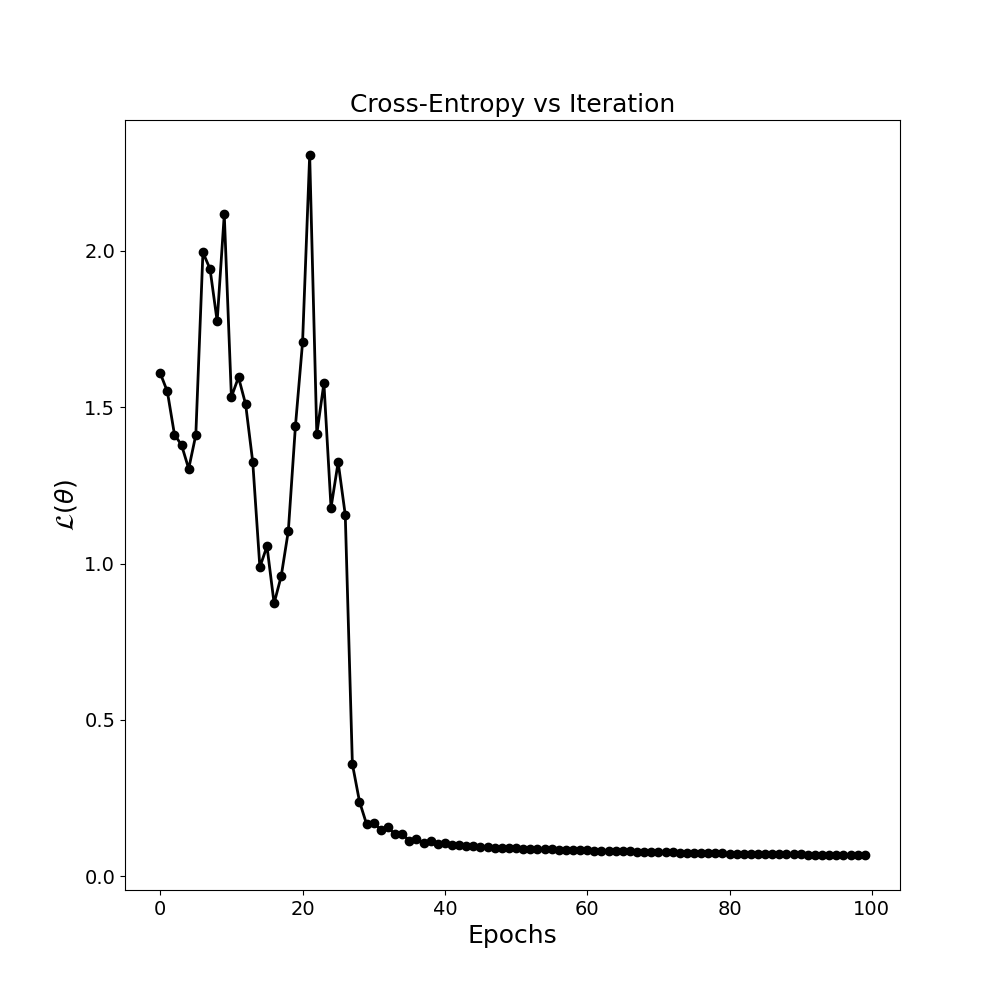

In [7]:
# Loss values over the parameter path compared to the optimal loss
fig_ce, ax_loss_iter = plt.subplots(figsize=(10, 10))
ax_loss_iter.set_title("Cross-Entropy vs Iteration")
plt.plot(np.array(trace['loss']), 'ko-', lw=2)
plt.xlabel("Epochs")
plt.ylabel(r"$\mathcal{L}(\theta)$")
plt.show()

Observe decision boundaries produced by the MLP for this $C=5$ class setting:

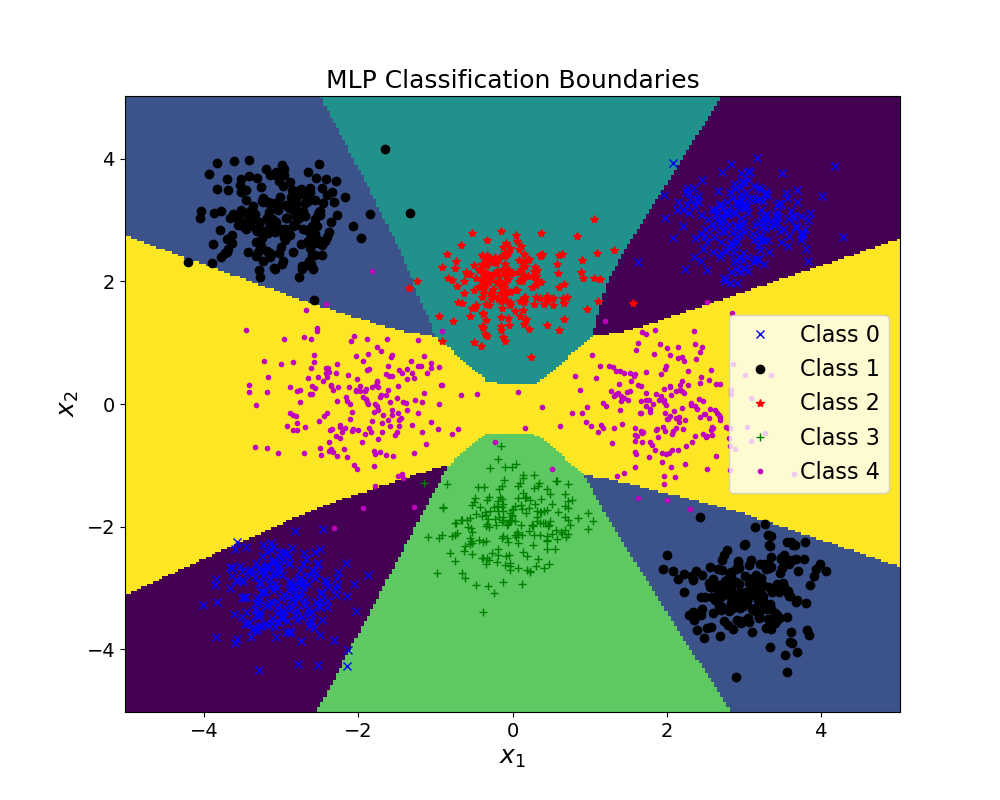

In [8]:
def model_predict(model, data):
    # Similar idea to model.train(), set a flag to let network know your in "inference" mode
    model.eval()
    # Disabling gradient calculation is useful for inference, only forward pass!!
    with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        predicted_labels = model(data)
        # Back to numpy
        predicted_labels = predicted_labels.detach().numpy()

        return np.argmax(predicted_labels, 1)
# Create coordinate matrices determined by the sample space
xx, yy = np.meshgrid(np.linspace(-5, 5, 250), np.linspace(-5, 5, 250))

grid = np.c_[xx.ravel(), yy.ravel()]

net_outs = forward_prop(grid, theta_gd)
# Argmax to convert probabilities into ordinal label predictions
net_predictions = np.argmax(net_outs['probs'], 1)
# Z matrix are the predictions resulting from the forward pass through the network
Z = net_predictions.reshape(xx.shape)

plt.figure(figsize=(10,8))

# uses gray background for black dots
plt.pcolormesh(xx, yy, Z)
    
plt.plot(X[y==0, 0], X[y==0, 1], 'bx', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'ko', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'r*', label="Class 2");
plt.plot(X[y==3, 0], X[y==3, 1], 'g+', label="Class 3");
plt.plot(X[y==4, 0], X[y==4, 1], 'm.', label="Class 4");
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("MLP Classification Boundaries")
plt.legend()
plt.show()

Comment on the classification accuracy when the MLP is applied to an unseen test set of samples:

In [9]:
N_test = 10000
X_test, y_test = create_data(N_test)

net_outs = forward_prop(X_test, theta_gd)

net_predictions = np.argmax(net_outs['probs'], 1)
correct = np.sum(net_predictions == y_test)

# Times 8 as the create_data function actually creates N*num_gaussian (8) samples in total
correct /= (N_test*8)
print(f"Test Set Accuracy: {(100*correct):>0.1f}")

Test Set Accuracy: 98.1
